<a id='top'></a>

# Causality Analysis

# TODO

* ols assumptions for univariate analyses
    * residual plots
* forward selection
    * lines up more or less with chi square tests 
    * include some colinearity measure?
* logistic regression (binned seconds, binned total outs)
    * random forest does little better than random guessing
* business impact
* reorganize hypothesis tests section
    * univariate vs multivariate
    * cat v vat, cat v quant, quant v quant, quant v cat

## 1.0 Imports

### Import Libraries

In [1]:
# basic packages
import pandas as pd
import numpy as np
import random
import copy

# visualization packages
from ipywidgets import interact
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import graphviz 

# stats packages
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# sklearn modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# sklearn evaluation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score, calinski_harabasz_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
from matplotlib import colors
from itertools import cycle

def my_colors():
    tab = cycle(colors.TABLEAU_COLORS)
    return tab

### Load Data

[consider only feeds](#pairwise)

[consider feeds and operating conditions](#pairwise)

In [16]:
feeds = ['ADD ARGUS ARGUSTAT AT 31 HK',
 'ADD ARGUS ARGUTHERM AO 77 PP',
 'ADD POLYPLAST PPM AO 01 UV PP',
 'ADD SCHULMAN DTY 20 AOUV',
 'BEIGE SCHULMAN PZ 91738 1 5 ZA',
 'BLACK SCHULMAN P7381',
 'DEVAN 2SPIN PP 106',
 'GREEN POLYPLAST COLOUR MB PP 6821',
 'GREEN SCHULMAN PZ 302446 1 5 T',
 'High MFR Black',
 'GREEN SCHULMAN PZ 34198 1 5 T',
 'MFR 4 Black',
 'MFR 4 Black Brown',
 'High MFR Grey',
 'MFR 4 Green',
 'PP BOREALIS HE465FB',
 'MFR 4 Black Colour Blending',
 'PP INEOS 100 GA02',
 'PP INEOS 100 GA04',
 'PP INEOS 100 GA09',
 'MFR 4 Grey Colour Blending',
 'PP INEOS GA012',
 'PP POLYCHIM HB12XF',
 'MFR 4 White',
 'PP TOTAL 7089',
 'PP TOTAL PPH 4065',
 'MFR 4 White Colour Blending',
 'PP BOREALIS HE370FB',
 'PP UNIPETROL GB005',
 'SILIKAT PBH ABPP 05',
 'SILIKAT POLYPLUS AB 1001 PP',
 'UV ARGUS ARGUVIN UV 361 PP',
 'UV ARGUS ARX 904 11 PP',
 'UV ARGUS ARX 904 11 PP.1',
 'UV ARGUS ARX 904 11 PP.2',
 'UV POLYPLAST 6005 PP',
 'UV SCHULMAN FPPUV 38',
 'MFR 4 Grey',
 'PP POLYCHIM HL10XF',
 'MFR 4 Grey Grey',
 'PP POLYMER TEST MFI4',
 'PP TOTAL 4069',
 'RR MASTERBATCH TEST',
 'UV ARGUS ARX V 16 706 UV PP']

df = pd.read_csv('../../../../../Dropbox/work/mfganalytic/data/dupont/TyparMasterReportWithSampleDataImprovement2017-today.csv', header=1)
df = df.loc[df['Product'].notnull()]
df[feeds] = df[feeds].div(df[feeds].sum(axis=1), axis=0) #normalize feed rates
df['Time Delta'] = pd.to_datetime(df['Doff Time']).diff()
df['Total Seconds Out'] = df[[i for i in df.columns if 'Sec' in i]].sum(1)

# df.dropna(inplace=True)
hangs = [df.columns[i] for i, j in enumerate('Hang' in col for col in df.columns) if j]
speeds = [df.columns[i] for i, j in enumerate('speed' in col for col in df.columns) if j]
outs = [df.columns[i] for i, j in enumerate('Out' in col for col in df.columns) if j]
prods = df['Product'].unique()
counts = [i for i in df.columns if 'Count' in i]

#from LOEWEN
virgin_polymer = ['PP INEOS 100 GA04', 'PP POLYCHIM HB12XF', 'PP TOTAL 7089', #INEOS 100 GA09 until 2018 (2k rolls)
                  'PP TOTAL PPH 4065', 'PP UNIPETROL GB005', 'PP POLYCHIM HL10XF'] #HL10XF not used after 2016, #BOREALIS 

virgin_polymer = []
for col in df.columns:
    if ('PP INEOS' in col) or ('PP TOTAL' in col) or ('PP UNI' in col) or ('PP BORE' in col) or ('PP POLY' in col):
        virgin_polymer.append(col)

pressures = []
for col in df.columns:
    if 'Press' in col or 'PRESS' in col:
        pressures.append(col)
        
silicates = []
for col in df.columns:
    if 'SIL' in col:
        silicates.append(col)
uvs = []
for col in df.columns:
    if 'UV ' in col:
        uvs.append(col)

recycle = []
for col in df.columns:
    if 'MFR' in col:
        recycle.append(col)
        
seconds = []
for col in df.columns:
    if 'Sec' in col:
        seconds.append(col)

master_batch = list(set(feeds) - set(recycle) - set(virgin_polymer))

operation = list(set(df.columns) - set(master_batch) - set(virgin_polymer) - set(recycle) -set(hangs) - set(outs))
operation.sort()

A summary of the columns

In [17]:
print(f'pressures: {len(pressures)}') 
print(f'silicates: {len(silicates)}') 
print(f'uvs: {len(uvs)}') 
print(f'feeds: {len(feeds)}') 
print(f'master_batch: {len(master_batch)}') 
print(f'virgin_polymer: {len(virgin_polymer)}')
print(f'recycle: {len(recycle)}') 
print(f'operation: {len(operation)}') 
print()
print(f'hangs: {len(hangs)}') 
print(f'speeds: {len(speeds)}') 
print(f'outs: {len(outs)}') 
print(f'seconds: {len(seconds)}') 
print()
print('summary target columns: TotalHangs, Total Position Out')
print()
print(df.shape)

pressures: 8
silicates: 2
uvs: 8
feeds: 44
master_batch: 20
virgin_polymer: 13
recycle: 11
operation: 180

hangs: 9
speeds: 9
outs: 10
seconds: 9

summary target columns: TotalHangs, Total Position Out

(17897, 243)


In [31]:
import datetime

In [41]:
df.columns

Index(['Millroll ID', 'Product', 'Roll Width', 'Sample Number', 'Doff Time',
       'Block1Pos Out Seconds', 'Block2Pos Out Seconds',
       'Block3Pos Out Seconds', 'Block4Pos Out Seconds', 'Block1Pos Out Count',
       ...
       'TKW5 AVG - Tack - Tear West 5 Meter',
       'TPOP - NUMBER OF TPO PEEKS (TPOP)', 'TTMD AVG - TRAP TEAR MD (TTMD)',
       'TTXD AVG - TRAP TEAR XD (TTXD)', 'UPEX - UWU PLOT EXTREM (UPEX)',
       'UWG - UWU GRAVIMETRIC WITH SCALE (UWG)',
       'UWGP AVG - UWU PLOT GRAVIMETRIC WITH SCALE (UWGP)',
       'WATP - WATER PERMEABILITY (WATP)', 'Time Delta', 'Total Seconds Out'],
      dtype='object', length=243)

In [50]:
df['Product'].name

'Product'

In [53]:
df[(pd.to_datetime(df['Doff Time']) < datetime.datetime(2018,1,1))
      & (pd.to_datetime(df['Doff Time']) >= datetime.datetime(2017,12,1))].groupby('Product')['Product', 'Roll Width'].apply(lambda x: x.count() 
                                                                                                                             if (x.name == 'Product') 
                                                                                                                             else (x.sum()))

/tmp/ipykernel_301/568605750.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[(pd.to_datetime(df['Doff Time']) < datetime.datetime(2018,1,1))


,Product,Roll Width
Product,,
0.0,0.0,20800.0
45235.0,1266580.0,147000.0
55235.0,110470.0,10400.0
55626.0,11458956.0,986560.0
62235.0,1244700.0,95500.0
68235.0,614115.0,37800.0
68236.0,341180.0,22800.0
90234.0,721872.0,42000.0
90617.0,2084191.0,119600.0


In [18]:
# uvs will be color
# recycle will be recycle
# silicates will be sprinkles
# virgin_polymer will be taffy_base

In [19]:
colors = ['red', 'green', 'white', 'blue', 'magenta', 'yellow', 'cyan', 'purple']
taffr = ['r213', 'r345', 'r093', 'r103', 'r194', 'r093', 'r298', 'r124', 'r000', 'r889', 'r299']
sprinkles = ['sprinkle1', 'sprinkle2']
taffy_base = ['taffy1', 'taffy2', 'taffy3', 'taffy4', 'taffy5', 'taffy6', 'taffy7', 'taffy8', 'taffy9', 'taffy10', 'taffy11', 'taffy12', 'taffy13']

In [5]:
all_feats = df.select_dtypes(float).columns[df.select_dtypes(float).columns.isin(feeds + operation)].values

In [76]:
hangs2 = [i.lower() for i in ['Block 1 Rips Seconds',
 'Block 2 Rips Seconds',
 'Block 3 Rips Seconds',
 'Block 4 Rips Seconds',
 'Block 1 Rips Count',
 'Block 2 Rips Count',
 'Block 3 Rips Count',
 'Block 4 Rips Count',
 'Total Rips']]

In [78]:
outs2 = [i.lower() for i in ['Block 1 Bumps Seconds',
 'Block 2 Bumps Seconds',
 'Block 3 Bumps Seconds',
 'Block 4 Bumps Seconds',
 'Block 1 Bumps Count',
 'Block 2 Bumps Count',
 'Block 3 Bumps Count',
 'Block 4 Bumps Count',
 'Total Bumps',
 'Total Seconds Out']]

In [79]:
taffy = pd.DataFrame()
taffy['product'] = df['Product']
taffy['date'] = df['Doff Time']
taffy[hangs2] = df[hangs]
taffy[outs2] = df[outs]
taffy[colors] = df[uvs]
taffy[taffr] = df[recycle]
taffy[sprinkles] = df[silicates]
taffy[taffy_base] = df[virgin_polymer]

In [80]:
taffy

,product,date,block 1 rips seconds,block 2 rips seconds,block 3 rips seconds,block 4 rips seconds,block 1 rips count,block 2 rips count,block 3 rips count,block 4 rips count,...,taffy4,taffy5,taffy6,taffy7,taffy8,taffy9,taffy10,taffy11,taffy12,taffy13
0,136215.0,1/1/2017 12:43:57 AM,9.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.357711,NaN,NaN,NaN,NaN,NaN
1,136215.0,1/1/2017 1:32:49 AM,NaN,29.0,103.0,NaN,NaN,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,0.291769,NaN,NaN,NaN,NaN,NaN
2,136215.0,1/1/2017 2:21:40 AM,11.0,NaN,9.0,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,0.293044,NaN,NaN,NaN,NaN,NaN
3,136215.0,1/1/2017 3:10:34 AM,NaN,198.0,219.0,NaN,NaN,4.0,2.0,NaN,...,NaN,NaN,NaN,NaN,0.308707,NaN,NaN,NaN,NaN,NaN
4,136215.0,1/1/2017 3:59:24 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.451992,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17892,90215.0,2/25/2019 7:56:16 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.382452,NaN,0.254966,NaN,NaN,NaN
17893,90215.0,2/25/2019 8:53:41 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.380653,NaN,0.253770,NaN,NaN,NaN
17894,90215.0,2/25/2019 9:51:06 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.378461,NaN,0.252311,NaN,NaN,NaN
17895,90215.0,2/25/2019 10:48:32 PM,NaN,NaN,223.0,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,0.379047,NaN,0.252599,NaN,NaN,NaN


## 2.0 Understand The Dependent Variable

### What is the hit rate in these upset columns?

Around 7500 cases with no problem; 10000 cases with a position out

In [9]:
target = "Total Position Out"
df.groupby(target).apply(lambda x: x[target] > 0).value_counts()

True     10355
False     7542
Name: Total Position Out, dtype: int64

There are 30% higher incidence of hangs

In [10]:
target = "TotalHangs"
df.groupby(target).apply(lambda x: x[target] > 0).value_counts()

True     13954
False     3943
Name: TotalHangs, dtype: int64

In [11]:
target1 = "TotalHangs"
target2 = "Total Position Out"
print(f"both upsets: {df.loc[(df[target1] > 0) & (df[target2] > 0)].shape[0]}")
print(f"only hangs: {df.loc[(df[target1] > 0) & (df[target2] == 0)].shape[0]}")
print(f"only outs: {df.loc[(df[target1] == 0) & (df[target2] > 0)].shape[0]}")
print(f"neither upset: {df.loc[(df[target1] == 0) & (df[target2] == 0)].shape[0]}")

both upsets: 10161
only hangs: 3793
only outs: 194
neither upset: 3749


### What is the magnitude of the outages?

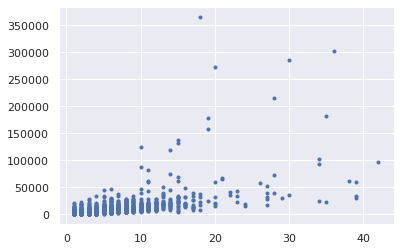

In [12]:
target = "Total Position Out"
y = df.loc[df[target] > 0][[i for i in outs if 'Sec' in i]].sum(axis=1)
x = df.loc[df[target] > 0][target]
plt.plot(x, y, ls='', marker='.')

In [13]:
pd.DataFrame([x,y]).T.corr()

,Total Position Out,Unnamed 0
Total Position Out,1.00000,0.62591
Unnamed 0,0.62591,1.00000


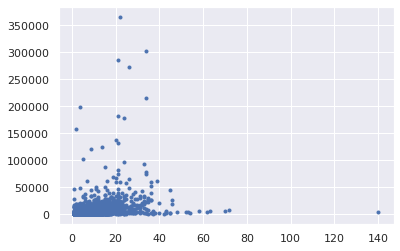

In [14]:
target = "TotalHangs"
y = df.loc[df[target] > 0][[i for i in outs if 'Sec' in i]].sum(axis=1)
x = df.loc[df[target] > 0][target]
plt.plot(x, y, ls='', marker='.')

In [15]:
pd.DataFrame([x,y]).T.corr()

,TotalHangs,Unnamed 0
TotalHangs,1.000000,0.390949
Unnamed 0,0.390949,1.000000


### Distribution around the target variable, total seconds

We will certainly encounter trouble in an OLS estimate with this shape of the target variable; extreme skewness, upper tail, perhaps outliers

In [404]:
tot_seconds = df[seconds].sum(1)
tot_seconds.kurt()

923.6728632470827

In [405]:
tot_seconds.skew()

25.09323820232841

<AxesSubplot:ylabel='Density'>

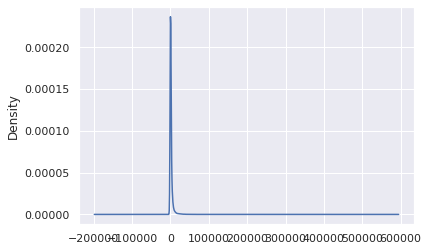

In [406]:
tot_seconds.plot.kde()

In [407]:
tot_seconds.describe()

count     17897.000000
mean       2093.512879
std        8060.466090
min           0.000000
25%          20.000000
50%         666.000000
75%        1970.000000
max      396570.000000
dtype: float64

### Do block positions have the same behavior?

In [383]:
target = "TotalHangs"
df.groupby(target)[hangs].count()

,Block1Hangs Seconds,Block2Hangs Seconds,Block3Hangs Seconds,Block4Hangs Seconds,Block1Hangs Count,Block2Hangs Count,Block3Hangs Count,Block4Hangs Count,TotalHangs
TotalHangs,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,3943
1.0,510,682,745,977,510,682,745,977,2914
2.0,709,761,901,1109,709,761,901,1109,2424
3.0,721,776,930,1103,721,776,930,1103,1929
4.0,700,773,875,993,700,773,875,993,1577
5.0,609,668,744,828,609,668,745,828,1189
6.0,523,498,599,631,523,498,599,631,883
7.0,387,414,472,505,387,414,472,505,640
8.0,321,338,376,409,321,338,376,409,503


<AxesSubplot:>

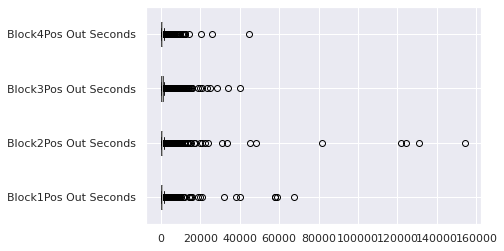

In [384]:
df[[i for i in outs if 'Sec' in i]].boxplot(vert=False)

<AxesSubplot:>

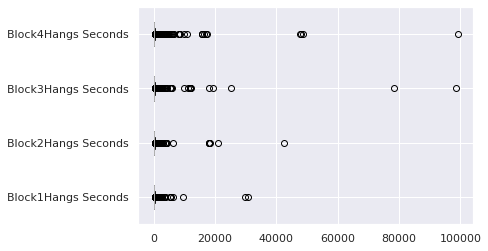

In [385]:
df[[i for i in hangs if 'Sec' in i]].boxplot(vert=False)

## 3.0 Look for dependent-independent signal 

### Are there linear relationships between the dependent and independent variables?

In [408]:
corr = df.corr()

In [409]:
(abs(corr[outs+hangs]) > 0.3).any(axis=1)

Product                                              False
Roll Width                                           False
Block1Pos Out Seconds                                 True
Block2Pos Out Seconds                                 True
Block3Pos Out Seconds                                 True
                                                     ...  
UPEX - UWU PLOT EXTREM (UPEX)                        False
UWG - UWU GRAVIMETRIC WITH SCALE (UWG)               False
UWGP AVG - UWU PLOT GRAVIMETRIC WITH SCALE (UWGP)    False
WATP - WATER PERMEABILITY (WATP)                     False
Total Seconds Out                                     True
Length: 237, dtype: bool

In [410]:
cor_filt = corr.loc[(abs(corr[outs+hangs]) > 0.3).any(axis=1)].drop(labels=outs+hangs, axis=0)[outs+hangs]
cor_filt

,Block1Pos Out Seconds,Block2Pos Out Seconds,Block3Pos Out Seconds,Block4Pos Out Seconds,Block1Pos Out Count,Block2Pos Out Count,Block3Pos Out Count,Block4Pos Out Count,Total Position Out,Total Seconds Out,Block1Hangs Seconds,Block2Hangs Seconds,Block3Hangs Seconds,Block4Hangs Seconds,Block1Hangs Count,Block2Hangs Count,Block3Hangs Count,Block4Hangs Count,TotalHangs
ADD ARGUS ARGUSTAT AT 31 HK,-0.103999,-0.417688,-0.383222,0.202131,-0.056194,-0.412274,0.155126,0.145535,0.014216,0.029563,0.121682,-0.256723,-0.012676,0.099690,-0.069354,-0.041492,0.094150,0.041900,0.344896
PP INEOS 100 GA02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
MFR 4 White,0.289648,-0.016268,0.451446,-0.155932,0.297256,-0.000098,0.376795,-0.003129,0.225425,0.182687,0.231764,-0.045076,0.283286,-0.119481,0.108396,-0.057188,0.317089,0.008018,0.189109
PP TOTAL 7089,0.160268,0.171023,0.210796,0.093720,0.192159,0.210942,0.206859,0.076058,0.260505,0.207522,0.087954,0.050670,0.052622,-0.050506,0.218148,0.251676,0.134881,0.121080,0.331897
SILIKAT POLYPLUS AB 1001 PP,0.015132,0.125801,0.379559,0.255662,-0.018715,0.012019,0.161698,0.067661,0.127830,0.137376,-0.016317,-0.018187,-0.018956,0.086781,0.011207,-0.020307,0.092291,0.109259,0.069217
RJET15219WG1 - Corona Charge I AVG BLK#2,-0.120204,-0.120509,-0.056377,-0.002054,-0.198138,-0.221189,-0.193393,-0.024541,-0.232863,-0.149862,-0.090896,-0.060404,-0.054169,-0.052683,-0.215325,-0.216545,-0.182990,-0.120387,-0.308217
BLFL - COLOUR BLACK FILAMENT L value (BLFL),-0.360086,-0.157845,-0.245565,-0.268837,-0.153321,-0.162697,-0.212481,-0.247721,-0.067632,-0.121690,0.097783,0.146515,-0.346923,-0.110987,0.402310,-0.274153,-0.378670,-0.116264,-0.117501
BRFA - COLOUR BROWN FILAMENT a value (BRFa),0.159056,0.250229,-0.384880,0.109024,0.134248,0.112836,-0.380715,-0.054074,0.099040,0.166926,0.170184,-0.065344,-0.195062,0.094596,0.195404,-0.333632,-0.026209,0.177576,0.173995
BRFB - COLOUR BROWN FILAMENT b value (BRFb),0.413876,0.047748,0.332752,0.342115,0.145794,-0.028170,0.246787,0.234624,0.216156,0.311363,0.148441,-0.210193,0.118275,0.285286,-0.027055,-0.275750,0.100830,0.328240,0.164345
BRFL - COLOUR BROWN FILAMENT L value (BRFL),0.198864,-0.178050,0.483242,0.205796,0.017456,-0.220432,0.411110,0.090885,0.039031,0.128326,0.337130,-0.326368,0.075738,0.145878,0.195055,-0.467536,-0.075130,0.188013,-0.000575


<AxesSubplot:>

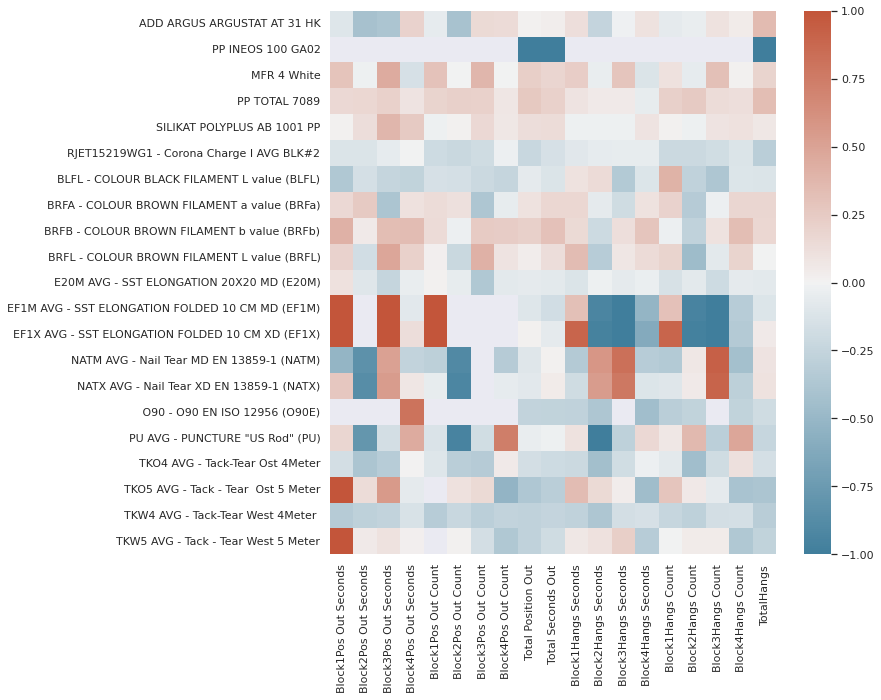

In [411]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_filt, cmap=cmap)

#### Filter N > 100

In [412]:
cor_filt = cor_filt.loc[[df[item].dropna().shape[0] > 100 for item in cor_filt.index]]

<AxesSubplot:>

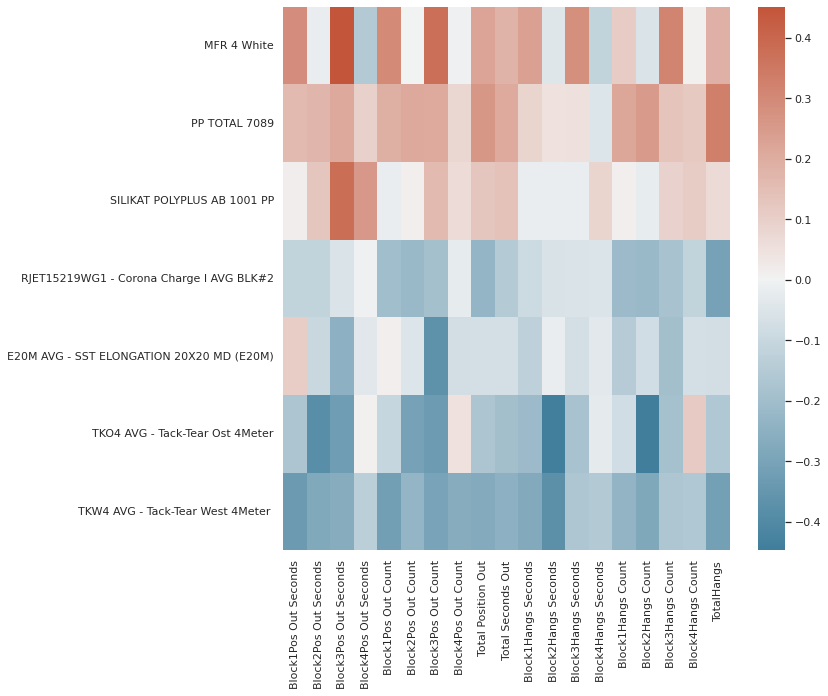

In [413]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_filt.loc[[df[item].dropna().shape[0] > 100 for item in cor_filt.index]], cmap=cmap)

#### Operating Conditions

Text(0.5, 1.0, 'Operations Correlations to Hangs and Outs')

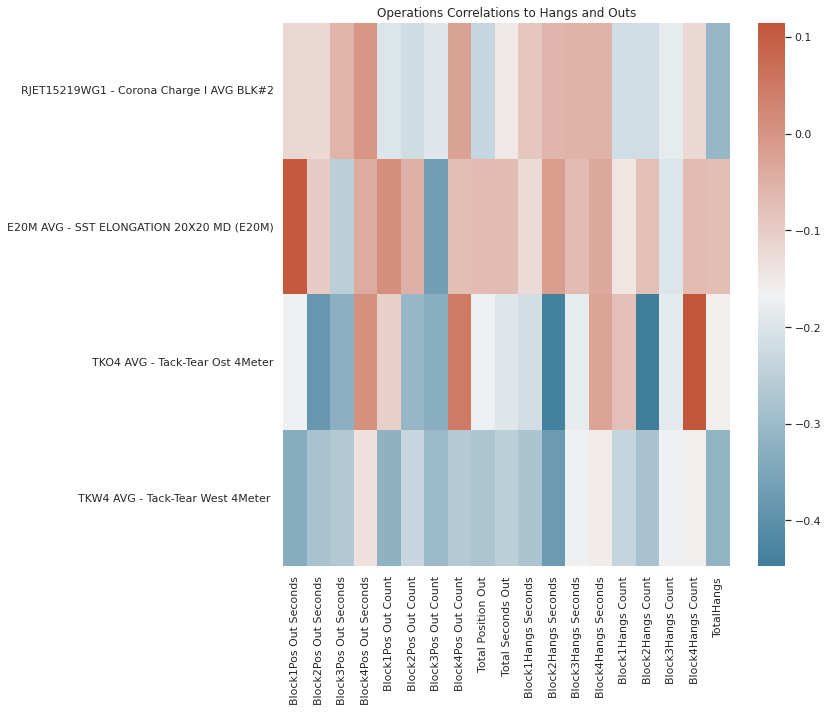

In [414]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_filt.loc[cor_filt.index.isin(operation)], cmap=cmap)
ax.set_title("Operations Correlations to Hangs and Outs")

#### Feeds

Text(0.5, 1.0, 'Feeds Correlations to Hangs and Outs')

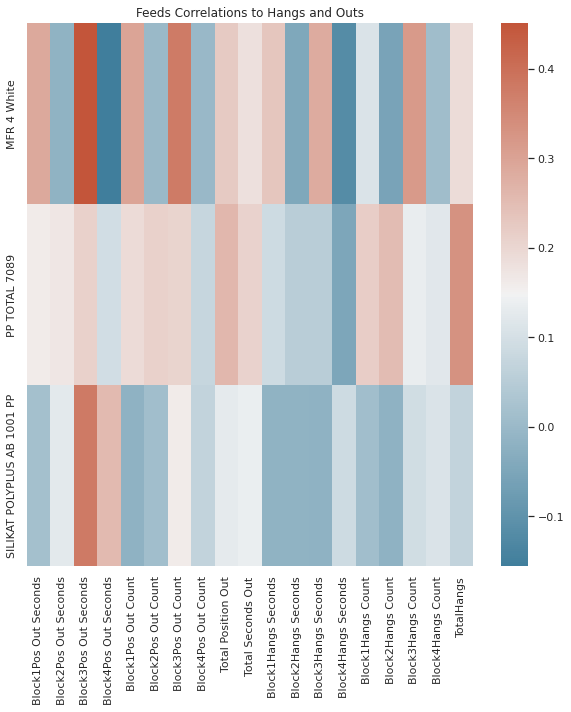

In [415]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_filt.loc[~cor_filt.index.isin(operation)], cmap=cmap)
ax.set_title("Feeds Correlations to Hangs and Outs")

In [416]:
ind_vars = list(cor_filt.index[~cor_filt.index.isin(operation)])
ind_vars

['MFR 4 White', 'PP TOTAL 7089', 'SILIKAT POLYPLUS AB 1001 PP']

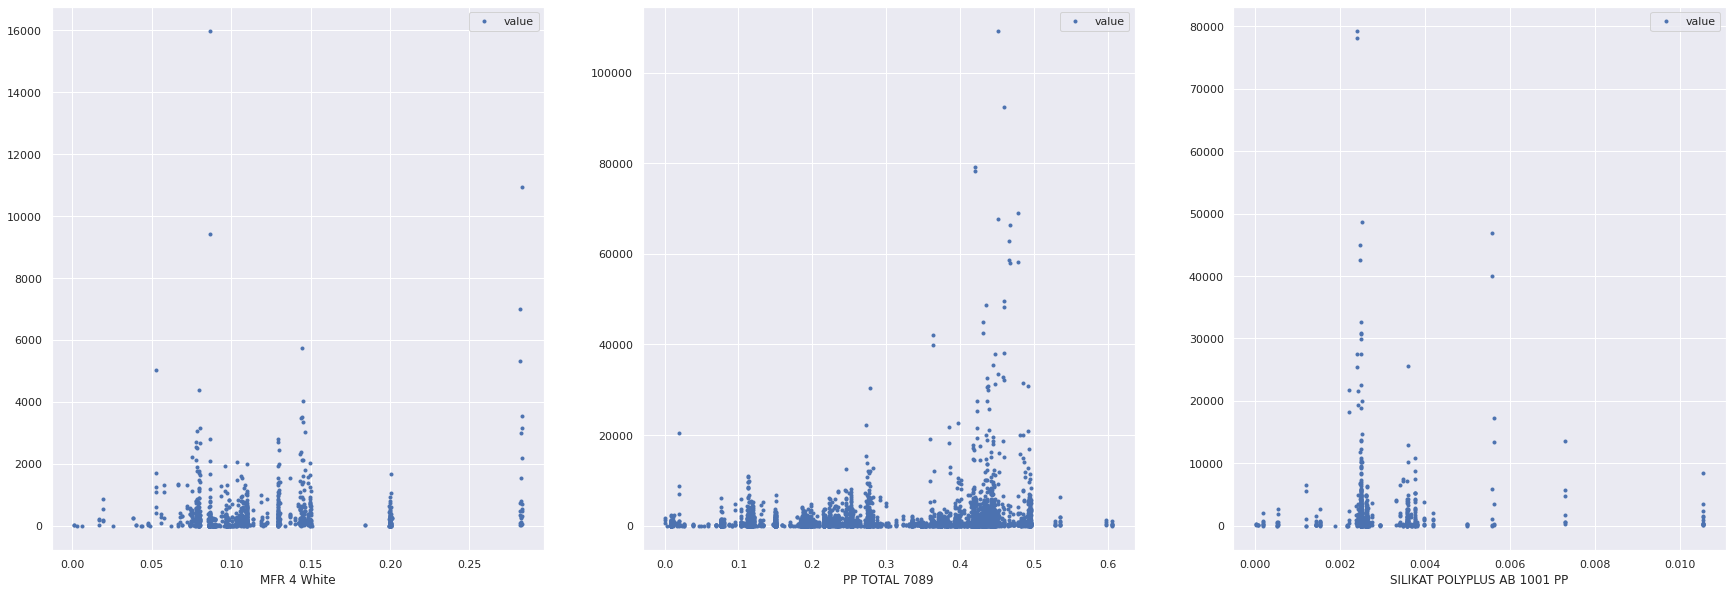

In [417]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
indices = np.argwhere(ax)
for index, ind_var in enumerate(ind_vars):
    df[[ind_var] + seconds].melt(id_vars=ind_var,
                                    value_vars=None,
                                    var_name=None,).plot(x=ind_var, y='value', ax=ax[index], ls='', marker='.')

## 4.0 Understand the Independent Variable

### Descriptive Stats on Ind Var

all the feeds sum to 1 (feeds are mass or volume fractions), so we probably won't need to worry about scaling

In [418]:
df[feeds].sum(1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
17892    1.0
17893    1.0
17894    1.0
17895    1.0
17896    1.0
Length: 17897, dtype: float64

many of the feeds are not used at all

In [419]:
skew = df[feeds].skew()
kurt = df[feeds].kurtosis()
null = df[feeds].isnull().sum()
n = df[feeds].notnull().sum()
med = df[feeds].median()
men = df[feeds].mean()

dff = pd.DataFrame([skew, kurt, null, n, med, men])
dff = dff.T
dff.columns = ['skew', 'kurtosis', 'null cnt', 'n', 'median', 'mean']
dff.loc[dff['n'] > 0]

,skew,kurtosis,null cnt,n,median,mean
ADD ARGUS ARGUSTAT AT 31 HK,-1.122018,-0.275303,17798.0,99.0,0.006560,0.005080
ADD ARGUS ARGUTHERM AO 77 PP,14.927951,248.300227,15627.0,2270.0,0.005249,0.010705
ADD POLYPLAST PPM AO 01 UV PP,5.788514,87.051660,16769.0,1128.0,0.006397,0.006218
ADD SCHULMAN DTY 20 AOUV,6.573319,99.052816,13484.0,4413.0,0.004997,0.005411
BEIGE SCHULMAN PZ 91738 1 5 ZA,-0.455858,10.108094,16975.0,922.0,0.008922,0.008708
BLACK SCHULMAN P7381,2.301415,16.313957,4471.0,13426.0,0.000317,0.002040
DEVAN 2SPIN PP 106,0.770601,11.066370,13279.0,4618.0,0.006658,0.005554
GREEN POLYPLAST COLOUR MB PP 6821,-1.856631,3.540741,16894.0,1003.0,0.007519,0.006822
GREEN SCHULMAN PZ 302446 1 5 T,0.363239,8.864015,17150.0,747.0,0.018764,0.018006
High MFR Black,0.473484,-1.518082,14862.0,3035.0,0.047883,0.146677


our `ind_vars` feeds have some strong correlations with other feeds

In particular, `PP TOTAL 7089` and `SILIKAT POLYPLUS AB 1001 PP` have a correlation w/ eachother of .923

In [420]:
ind_corr = df[feeds].corr()[ind_vars].dropna(how='all')
ind_corr.loc[(abs(ind_corr) > 0.5).any(1)]

,MFR 4 White,PP TOTAL 7089,SILIKAT POLYPLUS AB 1001 PP
ADD SCHULMAN DTY 20 AOUV,-0.741967,-0.057221,-0.875009
High MFR Black,NaN,-0.351428,0.538436
MFR 4 Black,-0.442742,0.876072,-0.602269
PP INEOS 100 GA09,NaN,-0.654004,NaN
PP POLYCHIM HB12XF,NaN,-0.697618,0.322222
MFR 4 White,1.000000,NaN,NaN
PP TOTAL 7089,NaN,1.000000,0.923427
PP UNIPETROL GB005,-0.634001,-0.713590,0.148101
SILIKAT POLYPLUS AB 1001 PP,NaN,0.923427,1.000000


`ind_vars` feeds exhibit bimodal distributions (2+ recipes)

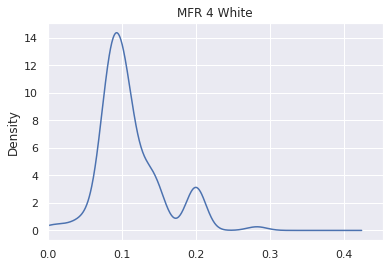

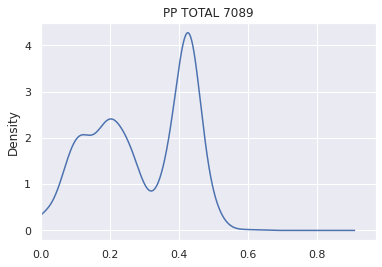

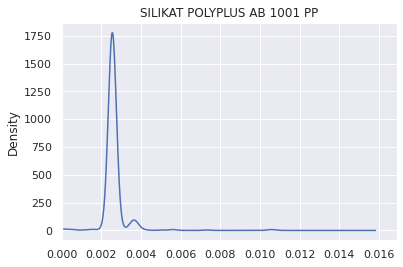

In [421]:
for ind in ind_vars:
    df[ind].plot.kde()
    plt.title(ind)
    plt.xlim(0)
    plt.show()

## 5.0 Hypothesis Tests

### Non-Parametric

#### Univariate Categorical to Categorical (Chi-Square)

In [422]:
ind_vars

['MFR 4 White', 'PP TOTAL 7089', 'SILIKAT POLYPLUS AB 1001 PP']

In [423]:
chidf = pd.DataFrame()
target = 'Total Position Out'
chidf[target] = df[target] > 0
for ind in ind_vars:
    chidf[ind] = (df[ind] > 0 ) | (df[ind].notnull())
    display(chidf.groupby(ind)[target].value_counts())
    
    # in cTable, populations are rows (Tot Pos Out)
    # groups are columns (w/ the feed w/o the feed)
    cTable = (chidf.groupby(ind)[target].value_counts().values).reshape(2,2).T
    print(cTable)
    chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
    print(f"chi2 stat: {chi2:.2f} \tp-value: {p:.2e}")
    print()

MFR 4 White  Total Position Out
False        True                  10182
             False                  7377
True         True                    173
             False                   165
Name: Total Position Out, dtype: int64

[[10182   173]
 [ 7377   165]]
chi2 stat: 6.02 	p-value: 1.41e-02



PP TOTAL 7089  Total Position Out
False          True                  9171
               False                 7175
True           True                  1184
               False                  367
Name: Total Position Out, dtype: int64

[[9171 1184]
 [7175  367]]
chi2 stat: 237.00 	p-value: 1.78e-53



SILIKAT POLYPLUS AB 1001 PP  Total Position Out
False                        True                  9996
                             False                 7364
True                         True                   359
                             False                  178
Name: Total Position Out, dtype: int64

[[9996  359]
 [7364  178]]
chi2 stat: 17.99 	p-value: 2.22e-05



In [424]:
chidf = pd.DataFrame()
target = 'Total Position Out'
chidf[target] = df[target] > 0
chisum = pd.DataFrame()
cutoff = 0.01
for ind in feeds:
    chidf[ind] = (df[ind] > 0 ) | (df[ind].notnull())   
    try:
        cTable = (chidf.groupby(ind)[target].value_counts().values).reshape(2,2).T
        chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
        ratio = cTable[0]/cTable[1]
        pos = ratio[0]/ratio[1] > 1
        chisum = pd.concat([chisum, pd.DataFrame([[ind, chi2, p, cTable, pos, p<cutoff]])])
    except:
        # print(f"\t\t{ind} returned error; n: {chidf[ind].sum()}")
        pass

chisum.columns = ['feed', 'chi', 'p-value', 'cTable', '+', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

In [425]:
chisum['type'] = None
chisum.loc[chisum['feed'].isin(master_batch), 'type'] = 'master_batch'
chisum.loc[chisum['feed'].isin(recycle), 'type'] = 'recyle'
chisum.loc[chisum['feed'].isin(virgin_polymer), 'type'] = 'virgin_polymer'
chisum.loc[chisum['feed'].isin(silicates), 'type'] = 'silicates'
chisum.loc[chisum['feed'].isin(uvs), 'type'] = 'uvs'

In [426]:
chisum.loc[chisum['reject null'] == True]

,feed,chi,p-value,cTable,+,reject null,type
0,PP TOTAL 7089,236.997695,1.775656e-53,"[[9171, 1184], [7175, 367]]",False,True,virgin_polymer
1,PP POLYCHIM HB12XF,160.530330,8.665205e-37,"[[9338, 1017], [7187, 355]]",False,True,virgin_polymer
2,High MFR Grey,136.568590,1.498471e-31,"[[8956, 1399], [6944, 598]]",False,True,recyle
3,SILIKAT PBH ABPP 05,125.809746,3.384213e-29,"[[9008, 1347], [6959, 583]]",False,True,silicates
4,BLACK SCHULMAN P7381,105.280707,1.060033e-24,"[[2353, 8237], [2118, 5189]]",False,True,master_batch
5,PP INEOS 100 GA09,53.633573,2.415953e-13,"[[9605, 750], [7197, 345]]",False,True,virgin_polymer
6,ADD ARGUS ARGUTHERM AO 77 PP,49.779216,1.720570e-12,"[[8886, 1469], [6741, 801]]",False,True,master_batch
7,DEVAN 2SPIN PP 106,35.237690,2.918209e-09,"[[7511, 2844], [5768, 1774]]",False,True,master_batch
8,High MFR Black,34.917755,3.439303e-09,"[[8452, 1903], [6410, 1132]]",False,True,recyle
9,GREEN POLYPLAST COLOUR MB PP 6821,29.252089,6.354766e-08,"[[9692, 663], [7202, 340]]",False,True,master_batch


##### Check confounding variables

**Isolate Products (product conflation with feed)**

Let's isolate the comparison by _only_ products made with the feed (`ind_var`) in question

We see that `MFR 4 White` and `SILIKAT POLYPLUS AB 1001 PP` are very imbalanced compared to `PP TOTAL 7089`

In [427]:
target = 'Total Position Out'

for ind in ind_vars:
    chidf = pd.DataFrame()
    # isolate products made with `ind`
    dff = df.loc[df['Product'].isin(df.loc[df[ind] > 0]['Product'].unique())]
    chidf[target] = dff[target] > 0
    chidf[ind] = dff[ind] > 0
    display(chidf.groupby(ind)[target].value_counts())
    
    # in cTable, populations are rows (Tot Pos Out)
    # groups are columns (w/ the feed w/o the feed)
    cTable = (chidf.groupby(ind)[target].value_counts().values).reshape(2,2).T
    print(cTable)
    chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
    print(f"chi2 stat: {chi2:.2f} \tp-value: {p:.2e}")
    print()

MFR 4 White  Total Position Out
False        True                  3978
             False                 2933
True         True                   173
             False                  165
Name: Total Position Out, dtype: int64

[[3978  173]
 [2933  165]]
chi2 stat: 5.10 	p-value: 2.40e-02



PP TOTAL 7089  Total Position Out
False          True                  2301
               False                 1393
True           True                  1184
               False                  367
Name: Total Position Out, dtype: int64

[[2301 1184]
 [1393  367]]
chi2 stat: 96.05 	p-value: 1.12e-22



SILIKAT POLYPLUS AB 1001 PP  Total Position Out
False                        True                  2418
                             False                 1602
True                         True                   359
                             False                  178
Name: Total Position Out, dtype: int64

[[2418  359]
 [1602  178]]
chi2 stat: 8.66 	p-value: 3.25e-03



In [428]:
target = 'Total Position Out'
chisum2 = pd.DataFrame()
cutoff = 0.01
for ind in feeds:
    
    chidf = pd.DataFrame()    
    # isolate products made with `ind`
    dff = df.loc[df['Product'].isin(df.loc[df[ind] > 0]['Product'].unique())]
    chidf[target] = dff[target] > 0
    chidf[ind] = dff[ind] > 0
    
    try:
        cTable = (chidf.groupby(ind)[target].value_counts().values).reshape(2,2).T
        chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
        ratio = cTable[0]/cTable[1]
        pos = ratio[0]/ratio[1] > 1
        chisum2 = pd.concat([chisum2, pd.DataFrame([[ind, chi2, p, cTable, pos, p<cutoff]])])
    except:
        # print(f"\t\t{ind} returned error; n: {chidf[ind].sum()}")
        pass

chisum2.columns = ['feed', 'chi', 'p-value', 'cTable', '+', 'reject null']
chisum2 = chisum2.sort_values('p-value').reset_index(drop=True)

In [429]:
tests = chisum.set_index('feed').join(chisum2.set_index('feed')[['p-value', 'reject null']], rsuffix=', confound')
tests.loc[(tests['reject null'] == True) & (tests['reject null, confound'] == True)]

,chi,p-value,cTable,+,reject null,type,"p-value, confound","reject null, confound"
feed,,,,,,,,
PP TOTAL 7089,236.997695,1.775656e-53,"[[9171, 1184], [7175, 367]]",False,True,virgin_polymer,1.118476e-22,True
PP POLYCHIM HB12XF,160.530330,8.665205e-37,"[[9338, 1017], [7187, 355]]",False,True,virgin_polymer,2.117300e-10,True
High MFR Grey,136.568590,1.498471e-31,"[[8956, 1399], [6944, 598]]",False,True,recyle,3.703831e-20,True
SILIKAT PBH ABPP 05,125.809746,3.384213e-29,"[[9008, 1347], [6959, 583]]",False,True,silicates,1.053579e-05,True
BLACK SCHULMAN P7381,105.280707,1.060033e-24,"[[2353, 8237], [2118, 5189]]",False,True,master_batch,1.224043e-26,True
PP INEOS 100 GA09,53.633573,2.415953e-13,"[[9605, 750], [7197, 345]]",False,True,virgin_polymer,1.089179e-03,True
ADD ARGUS ARGUTHERM AO 77 PP,49.779216,1.720570e-12,"[[8886, 1469], [6741, 801]]",False,True,master_batch,3.540298e-10,True
High MFR Black,34.917755,3.439303e-09,"[[8452, 1903], [6410, 1132]]",False,True,recyle,6.799384e-03,True
GREEN POLYPLAST COLOUR MB PP 6821,29.252089,6.354766e-08,"[[9692, 663], [7202, 340]]",False,True,master_batch,1.482338e-11,True


we can compare this with our feed correlation table - there may be other explanatory variables 'hiding'

In [430]:
ind_corr.loc[(abs(ind_corr) > 0.3).any(1)]

,MFR 4 White,PP TOTAL 7089,SILIKAT POLYPLUS AB 1001 PP
ADD SCHULMAN DTY 20 AOUV,-0.741967,-0.057221,-0.875009
BLACK SCHULMAN P7381,0.196431,-0.470838,0.082699
DEVAN 2SPIN PP 106,NaN,-0.415896,0.097590
High MFR Black,NaN,-0.351428,0.538436
MFR 4 Black,-0.442742,0.876072,-0.602269
PP INEOS 100 GA04,0.342077,-0.248904,0.402788
PP INEOS 100 GA09,NaN,-0.654004,NaN
PP POLYCHIM HB12XF,NaN,-0.697618,0.322222
MFR 4 White,1.000000,NaN,NaN
PP TOTAL 7089,NaN,1.000000,0.923427


#### Univariate Categorical to Quantitative (Moods Median)

A limitation of the previous analysis is that our threshold for counting an upset in the line was pretty low - any delay (position out > 0 seconds). A way we can naturally increase this threshold is to compare medians (of position out (secs)) across our groups.

In [431]:
chidf = pd.DataFrame()
target = 'Seconds'
chidf[target] = df[seconds].sum(1)
moods = pd.DataFrame()
cutoff = 0.01
pop = chidf[target].values

for ind in feeds:
    try:
        chidf[ind] = (df[ind] > 0 ) | (df[ind].notnull())
        grp = chidf.loc[chidf[ind] == True][target].values
        chi2, p, m, cTable = stats.median_test(grp, pop, correction=False)
        ratio = cTable[0]/cTable[1]
        pos = ratio[0]/ratio[1] < 1
        moods = pd.concat([moods, pd.DataFrame([[ind, chi2, p, cTable, pos, p<cutoff]])])
    except:
        # print(f"\t\t{ind} returned error; n: {chidf[ind].sum()}")
        pass

moods.columns = ['feed', 'chi', 'p-value', 'cTable', '+', 'reject null']
moods = moods.sort_values('p-value').reset_index(drop=True)

In [432]:
moods.loc[moods['reject null'] == True]

,feed,chi,p-value,cTable,+,reject null
0,PP TOTAL 7089,284.071422,9.736103e-64,"[[1093, 8620], [458, 9277]]",False,True
1,MFR 4 Grey Grey,161.505327,5.305934e-37,"[[744, 9215], [1288, 8682]]",True,True
2,PP POLYCHIM HB12XF,140.079653,2.557382e-32,"[[897, 8734], [475, 9163]]",False,True
3,High MFR Grey,134.851343,3.558380e-31,"[[1244, 8697], [753, 9200]]",False,True
4,SILIKAT PBH ABPP 05,132.735135,1.033157e-30,"[[1205, 8704], [725, 9193]]",False,True
5,SILIKAT POLYPLUS AB 1001 PP,40.522176,1.943972e-10,"[[341, 8870], [196, 9027]]",False,True
6,DEVAN 2SPIN PP 106,39.379816,3.488847e-10,"[[2499, 8758], [2119, 9139]]",False,True
7,BLACK SCHULMAN P7381,33.697655,6.437826e-09,"[[6961, 8686], [6465, 9211]]",False,True
8,GREEN POLYPLAST COLOUR MB PP 6821,32.518968,1.180348e-08,"[[589, 8854], [414, 9043]]",False,True
9,PP INEOS 100 GA09,26.828649,2.223170e-07,"[[630, 8854], [465, 9043]]",False,True


we see that overall the moods test is _slightly_ less pessimistic

In [433]:
chisum['reject null'].value_counts()

True     16
False    16
Name: reject null, dtype: int64

In [434]:
moods['reject null'].value_counts()

True     17
False    15
Name: reject null, dtype: int64

In [435]:
testsf = tests.join(moods.set_index('feed')[['p-value', 'reject null']], lsuffix=', chi', rsuffix=', moods')
testsf.loc[(testsf['reject null, chi'] == True) & (testsf['reject null, moods'] == True) & (testsf['reject null, confound'] == True)]

,chi,"p-value, chi",cTable,+,"reject null, chi",type,"p-value, confound","reject null, confound","p-value, moods","reject null, moods"
feed,,,,,,,,,,
PP TOTAL 7089,236.997695,1.775656e-53,"[[9171, 1184], [7175, 367]]",False,True,virgin_polymer,1.118476e-22,True,9.736103e-64,True
PP POLYCHIM HB12XF,160.530330,8.665205e-37,"[[9338, 1017], [7187, 355]]",False,True,virgin_polymer,2.117300e-10,True,2.557382e-32,True
High MFR Grey,136.568590,1.498471e-31,"[[8956, 1399], [6944, 598]]",False,True,recyle,3.703831e-20,True,3.558380e-31,True
SILIKAT PBH ABPP 05,125.809746,3.384213e-29,"[[9008, 1347], [6959, 583]]",False,True,silicates,1.053579e-05,True,1.033157e-30,True
BLACK SCHULMAN P7381,105.280707,1.060033e-24,"[[2353, 8237], [2118, 5189]]",False,True,master_batch,1.224043e-26,True,6.437826e-09,True
PP INEOS 100 GA09,53.633573,2.415953e-13,"[[9605, 750], [7197, 345]]",False,True,virgin_polymer,1.089179e-03,True,2.223170e-07,True
ADD ARGUS ARGUTHERM AO 77 PP,49.779216,1.720570e-12,"[[8886, 1469], [6741, 801]]",False,True,master_batch,3.540298e-10,True,2.253660e-07,True
High MFR Black,34.917755,3.439303e-09,"[[8452, 1903], [6410, 1132]]",False,True,recyle,6.799384e-03,True,1.800242e-05,True
GREEN POLYPLAST COLOUR MB PP 6821,29.252089,6.354766e-08,"[[9692, 663], [7202, 340]]",False,True,master_batch,1.482338e-11,True,1.180348e-08,True


##### Non-Parametric Conclusions

In [436]:
problem_vars = testsf.loc[(testsf['reject null, chi'] == True) 
                        & (testsf['reject null, moods'] == True) 
                        & (testsf['reject null, confound'] == True)].iloc[:5].index

print(f"Compared with correlation\nthe dependency tests show that the top 5 problem variables are:\n{[f'{i}' for i in problem_vars]}")

Compared with correlation
the dependency tests show that the top 5 problem variables are:
['PP TOTAL 7089', 'PP POLYCHIM HB12XF', 'High MFR Grey', 'SILIKAT PBH ABPP 05', 'BLACK SCHULMAN P7381']


In [437]:
testsf.loc[(testsf['reject null, chi'] == True) & (testsf['reject null, moods'] == True) & (testsf['reject null, confound'] == True)].iloc[:5]

,chi,"p-value, chi",cTable,+,"reject null, chi",type,"p-value, confound","reject null, confound","p-value, moods","reject null, moods"
feed,,,,,,,,,,
PP TOTAL 7089,236.997695,1.775656e-53,"[[9171, 1184], [7175, 367]]",False,True,virgin_polymer,1.118476e-22,True,9.736103e-64,True
PP POLYCHIM HB12XF,160.530330,8.665205e-37,"[[9338, 1017], [7187, 355]]",False,True,virgin_polymer,2.117300e-10,True,2.557382e-32,True
High MFR Grey,136.568590,1.498471e-31,"[[8956, 1399], [6944, 598]]",False,True,recyle,3.703831e-20,True,3.558380e-31,True
SILIKAT PBH ABPP 05,125.809746,3.384213e-29,"[[9008, 1347], [6959, 583]]",False,True,silicates,1.053579e-05,True,1.033157e-30,True
BLACK SCHULMAN P7381,105.280707,1.060033e-24,"[[2353, 8237], [2118, 5189]]",False,True,master_batch,1.224043e-26,True,6.437826e-09,True


### Parametric

#### Univariate Quantitative to Quantitative (Linear Regression)

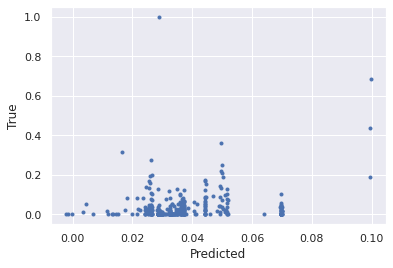

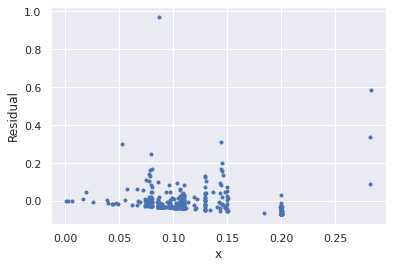

R2: 3.34e-02
RSE: 9.97e-03

b: -2.51e-03
m: 3.61e-01

n: 338
x_bar: 1.11e-01
SE_b: 1.51e-03
SE_m: 1.26e-02
test statistic: 28.56535956265302
p-value: 3.2661498371310494e-92


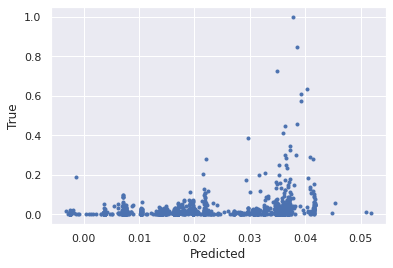

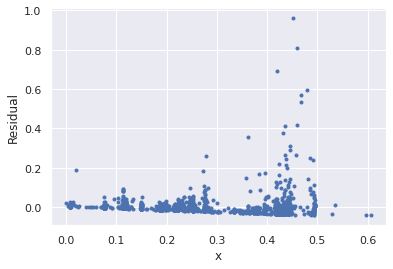

R2: 4.31e-02
RSE: 5.27e-03

b: -3.19e-03
m: 9.08e-02

n: 1551
x_bar: 2.89e-01
SE_b: 3.09e-04
SE_m: 9.66e-04
test statistic: 94.02166426512674
p-value: 0.0


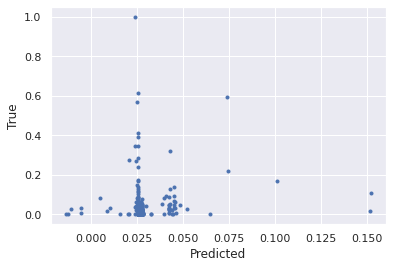

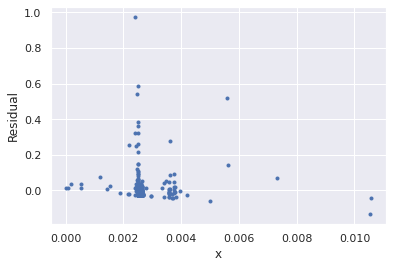

R2: 1.89e-02
RSE: 5.94e-03

b: -1.36e-02
m: 1.57e+01

n: 537
x_bar: 2.64e-03
SE_b: 1.04e-03
SE_m: 3.81e-01
test statistic: 41.11483903422569
p-value: 4.981863349397906e-168


In [439]:
for ind in ind_vars: 
    lindf = pd.DataFrame()
    lindf[ind] = df[ind]
    lindf['seconds'] = df['Total Seconds Out']
    
    lindf = lindf.dropna().reset_index(drop=True)

    x = lindf[ind].values.reshape(-1,1)
    y = lindf['seconds'].values
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    
    
    ### FIT AND HYP TEST
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    plt.plot(y_pred, y, ls='', marker='.')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    
    plt.plot(x, (y-y_pred), ls='', marker='.')
    plt.ylabel('Residual')
    plt.xlabel('x')
    plt.show()
    
    n = y.shape[0]
    print(f'R2: {r2_score(y, y_pred):.2e}')
    RSE = np.sqrt(r2_score(y, y_pred)/(n-2))
    print(f"RSE: {RSE:.2e}", end="\n\n")

    m = model.coef_[0][0]
    b = model.intercept_[0]

    # b_hat
    print(f"b: {b:.2e}")
    print(f"m: {m:.2e}", end="\n\n")
    
    print(f"n: {n}")
    x_bar = np.mean(x)
    print(f"x_bar: {x_bar:.2e}")
    

    SE_b = np.sqrt(RSE**2 * ((1/n) + x_bar**2/np.sum((x-x_bar)**2)))
    print(f"SE_b: {SE_b:.2e}")

    SE_m = np.sqrt(RSE**2/np.sum((x-x_bar)**2))
    print(f"SE_m: {SE_m:.2e}")


    t = m/SE_m
    print(f"test statistic: {t}")
    print(f"p-value: {stats.t.sf(x=t, df=n-2)}")

In [440]:
for ind in ind_vars: 
    lindf = pd.DataFrame()
    lindf[ind] = df[ind]
    lindf['seconds'] = df['Total Seconds Out']
    
    lindf = lindf.dropna().reset_index(drop=True)

    x = lindf[ind].values.reshape(-1,1)
    y = lindf['seconds'].values
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     11.60
Date:                Sat, 02 Apr 2022   Prob (F-statistic):           0.000739
Time:                        10:02:50   Log-Likelihood:                 360.28
No. Observations:                 338   AIC:                            -716.6
Df Residuals:                     336   BIC:                            -708.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.013     -0.199      0.8

##### Feature Engineering

Introducing polynomial features results in poor coefficient estimates

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     30.83
Date:                Sat, 02 Apr 2022   Prob (F-statistic):           2.35e-19
Time:                        10:03:01   Log-Likelihood:                 2190.9
No. Observations:                1551   AIC:                            -4374.
Df Residuals:                    1547   BIC:                            -4352.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.009      0.334      0.7

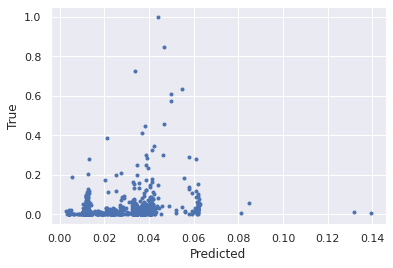

R2: 5.64e-02
RSE: 6.03e-03

b: 2.95e-03
m: 0.00e+00

n: 1551
x_bar: 3.58e-01
SE_b: 1.69e-04
SE_m: 1.96e-04
0.0
0.5


In [441]:
ind = ind_vars[1]
lindf = pd.DataFrame()
lindf[ind] = df[ind]
lindf['seconds'] = df['Total Seconds Out']

lindf = lindf.dropna().reset_index(drop=True)

x = lindf[ind].values.reshape(-1,1)
features = PolynomialFeatures(degree=3)
x = features.fit_transform(x.reshape(-1,1))
y = lindf['seconds'].values
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1, 1))


### FIT AND HYP TEST
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
    
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(y_pred, y, ls='', marker='.')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

n = y.shape[0]
print(f'R2: {r2_score(y, y_pred):.2e}')
RSE = np.sqrt(r2_score(y, y_pred)/(n-2))
print(f"RSE: {RSE:.2e}", end="\n\n")

m = model.coef_[0][0]
b = model.intercept_[0]

# b_hat
print(f"b: {b:.2e}")
print(f"m: {m:.2e}", end="\n\n")

print(f"n: {n}")
x_bar = np.mean(x)
print(f"x_bar: {x_bar:.2e}")


SE_b = np.sqrt(RSE**2 * ((1/n) + x_bar**2/np.sum((x-x_bar)**2)))
print(f"SE_b: {SE_b:.2e}")

SE_m = np.sqrt(RSE**2/np.sum((x-x_bar)**2))
print(f"SE_m: {SE_m:.2e}")


t = m/SE_m
print(t)
print(stats.t.sf(x=t, df=n-2))

#### Multivariate Quantitative to Quantitative (Multivariate Linear Regression)

In [442]:
lindf = pd.DataFrame()
lindf[feeds] = df[feeds]
lindf['seconds'] = df['Total Seconds Out']
lindf.fillna(0, inplace=True)
lindf

,ADD ARGUS ARGUSTAT AT 31 HK,ADD ARGUS ARGUTHERM AO 77 PP,ADD POLYPLAST PPM AO 01 UV PP,ADD SCHULMAN DTY 20 AOUV,BEIGE SCHULMAN PZ 91738 1 5 ZA,BLACK SCHULMAN P7381,DEVAN 2SPIN PP 106,GREEN POLYPLAST COLOUR MB PP 6821,GREEN SCHULMAN PZ 302446 1 5 T,High MFR Black,...,UV POLYPLAST 6005 PP,UV SCHULMAN FPPUV 38,MFR 4 Grey,PP POLYCHIM HL10XF,MFR 4 Grey Grey,PP POLYMER TEST MFI4,PP TOTAL 4069,RR MASTERBATCH TEST,UV ARGUS ARX V 16 706 UV PP,seconds
0,0.0,0.0,0.0,0.005337,0.0,0.000253,0.0,0.0,0.0,0.0,...,0.0,0.0,0.409353,0.0,0.0,0.0,0.0,0.0,0.000000,9.0
1,0.0,0.0,0.0,0.005867,0.0,0.000272,0.0,0.0,0.0,0.0,...,0.0,0.0,0.452007,0.0,0.0,0.0,0.0,0.0,0.000000,536.0
2,0.0,0.0,0.0,0.005895,0.0,0.000270,0.0,0.0,0.0,0.0,...,0.0,0.0,0.449608,0.0,0.0,0.0,0.0,0.0,0.000000,20.0
3,0.0,0.0,0.0,0.005743,0.0,0.000272,0.0,0.0,0.0,0.0,...,0.0,0.0,0.440883,0.0,0.0,0.0,0.0,0.0,0.000000,1001.0
4,0.0,0.0,0.0,0.004553,0.0,0.000211,0.0,0.0,0.0,0.0,...,0.0,0.0,0.349459,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17892,0.0,0.0,0.0,0.000000,0.0,0.000187,0.0,0.0,0.0,0.0,...,0.0,0.0,0.339726,0.0,0.0,0.0,0.0,0.0,0.002062,0.0
17893,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.342659,0.0,0.0,0.0,0.0,0.0,0.002071,0.0
17894,0.0,0.0,0.0,0.000000,0.0,0.000190,0.0,0.0,0.0,0.0,...,0.0,0.0,0.345886,0.0,0.0,0.0,0.0,0.0,0.002107,0.0
17895,0.0,0.0,0.0,0.000000,0.0,0.000187,0.0,0.0,0.0,0.0,...,0.0,0.0,0.344945,0.0,0.0,0.0,0.0,0.0,0.002095,799.0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     31.47
Date:                Sat, 02 Apr 2022   Prob (F-statistic):          2.76e-174
Time:                        10:03:19   Log-Likelihood:                 44791.
No. Observations:               17897   AIC:                        -8.952e+04
Df Residuals:                   17866   BIC:                        -8.928e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.002      5.316      0.0

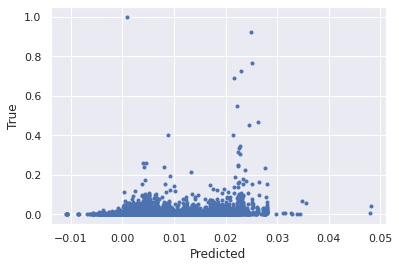

R2: 5.02e-02
RSE: 1.67e-03

b: 1.23e-02
m: -1.06e+00

n: 17897
x_bar: 2.26e-02
SE_b: 1.25e-05
SE_m: 2.14e-05
-49284.75476441197
1.0


In [443]:
lindf = pd.DataFrame()
lindf[feeds] = df[feeds]
lindf['seconds'] = df['Total Seconds Out']
lindf.fillna(0, inplace=True)

x = lindf[feeds].values
# features = PolynomialFeatures(degree=3)
# x = features.fit_transform(x.reshape(-1,1))
y = lindf['seconds'].values
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1, 1))


### FIT AND HYP TEST
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
    
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(y_pred, y, ls='', marker='.')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

n = y.shape[0]
print(f'R2: {r2_score(y, y_pred):.2e}')
RSE = np.sqrt(r2_score(y, y_pred)/(n-2))
print(f"RSE: {RSE:.2e}", end="\n\n")

m = model.coef_[0][0]
b = model.intercept_[0]

# b_hat
print(f"b: {b:.2e}")
print(f"m: {m:.2e}", end="\n\n")

print(f"n: {n}")
x_bar = np.mean(x)
print(f"x_bar: {x_bar:.2e}")


SE_b = np.sqrt(RSE**2 * ((1/n) + x_bar**2/np.sum((x-x_bar)**2)))
print(f"SE_b: {SE_b:.2e}")

SE_m = np.sqrt(RSE**2/np.sum((x-x_bar)**2))
print(f"SE_m: {SE_m:.2e}")


t = m/SE_m
print(t)
print(stats.t.sf(x=t, df=n-2))

##### Forward Selection

In [456]:
def add_feature(features, basemodel, data, y, r2max):
    for feed in features:
        
        basemodel[feed] = data[feed]
        basemodel.fillna(0, inplace=True)
        x = basemodel[[col for col in basemodel.columns if col != 'seconds']].values


        ### FIT AND HYP TEST
        X2 = sm.add_constant(x)
        est = sm.OLS(y, X2)
        est2 = est.fit()

        if (est2.rsquared > r2max) and not (est2.pvalues > cutoff).any():
            r2max = est2.rsquared
            feedmax = feed
            bestsum = est2.summary()
            newmodel = basemodel.copy()
        else:
            pass
        
        basemodel.drop(labels = feed, axis = 1, inplace = True)
    return r2max, feedmax, bestsum, newmodel

In [457]:
lindf = pd.DataFrame()
lindf['seconds'] = df['Total Seconds Out']
lindf.fillna(0, inplace=True)
y = lindf['seconds'].values
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1, 1))
r2max = 0
candidates = feeds.copy()
basemodel = lindf

while True:
    newr2max, feedmax, bestsum, newmodel = add_feature(
        features=candidates, 
        basemodel=basemodel, 
        data=df, 
        y=y,
        r2max=0)
    
    if newr2max > r2max:
        # print(newr2max, feedmax)
        candidates.remove(feedmax)
        r2max = newr2max
        basemodel = newmodel
        continue
    else:
        break

/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


we see some of the usual suspects from the chi-square tests. Notably some are missing: `High MFR Grey`, `BLACK SCHULMAN P7381`, `PP INEOS 100 GA09` and others.

In [458]:
basemodel.head()

,seconds,PP TOTAL 7089,PP POLYCHIM HB12XF,SILIKAT PBH ABPP 05,SILIKAT POLYPLUS AB 1001 PP,MFR 4 Green,ADD SCHULMAN DTY 20 AOUV,GREEN SCHULMAN PZ 302446 1 5 T,MFR 4 Grey,UV ARGUS ARX V 16 706 UV PP,GREEN SCHULMAN PZ 34198 1 5 T
0,9.0,0.0,0.0,0.0,0.0,0.0,0.005337,0.0,0.409353,0.0,0.0
1,536.0,0.0,0.0,0.0,0.0,0.0,0.005867,0.0,0.452007,0.0,0.0
2,20.0,0.0,0.0,0.0,0.0,0.0,0.005895,0.0,0.449608,0.0,0.0
3,1001.0,0.0,0.0,0.0,0.0,0.0,0.005743,0.0,0.440883,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.004553,0.0,0.349459,0.0,0.0


In [460]:
forward_selection_feeds = basemodel.columns[1:]

In [590]:
bestsum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     94.99
Date:                Sat, 02 Apr 2022   Prob (F-statistic):          5.51e-174
Time:                        10:04:41   Log-Likelihood:                 44748.
No. Observations:               17897   AIC:                        -8.948e+04
Df Residuals:                   17887   BIC:                        -8.940e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.000     11.288      0.000       0.003       0.004
x1             0.0214      0.002     11.535      0.000       0.018       0.025
x2             0.0146      0.002      7.837      0.000       0.011       0.018
x3             1.5742      0.110     14.375      0.000       1.360       1.789
x4             4.1700      0.363     11.497      0.000       3.459       4.881
x5            -0.0181      0.003     -6.276      0.000      -0.024      -0.012
x6            -0.2879      0.065     -4.450      0.000      -0.415      -0.161
x7            -0.1932      0.052     -3.698      0.000      -0.296      -0.091
x8             0.0037      0.001      3.322      0.001       0.002       0.006
x9             0.0736      0.028      2.641      0.008       0.019       0.128
x10                 0          0        nan        nan           0           0
x11                 0          0        nan        nan           0           0
==============================================================================
Omnibus:                    43415.763   Durbin-Watson:                   1.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        683838684.139
Skew:                          25.346   Prob(JB):                         0.00
Kurtosis:                     959.275   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Multivariate Conclusions

y poses a problem with out of the box regression. Extreme tails will upset the residual plots.

We some overlap of the parametric and non-parametric approaches:

In [447]:
[i for i in basemodel.columns if i in (problem_vars)]

['PP TOTAL 7089', 'PP POLYCHIM HB12XF', 'SILIKAT PBH ABPP 05']

#### Multivariate Quantitative to Categorical (Binned Output Variable)

Logistic regression does little better than random guessing

In [448]:
lindf = pd.DataFrame()
lindf['seconds'] = df['Total Seconds Out']
lindf.fillna(0, inplace=True)
y = lindf['seconds'].values
r2max = 0
candidates = feeds.copy()
basemodel = lindf

labels = y.copy()
labels[labels <= np.quantile(y, .25)] = 1
labels[(labels > np.quantile(y, .25)) & (labels <= np.quantile(y, .5))] = 2
labels[(labels > np.quantile(y, .5)) & (labels <= np.quantile(y, .75))] = 3
labels[(labels > np.quantile(y, .75))] = 4

names = []
names += [f"less than {np.quantile(y, .25):.2f} sec"]
names += [f"{np.quantile(y, .25):.2f} < sec <= {np.quantile(y, .5):.2f}"]
names += [f"{np.quantile(y, .5)/60:.2f} < min <= {np.quantile(y, .75)/60:.2f}"]
names += [f"greater than {np.quantile(y, .75)/60:.2f} min"]

y = labels
ind = feeds
lindf[ind] = df[ind]
lindf.fillna(0, inplace=True)
x = lindf[ind].values#.reshape(-1,1)

model = LogisticRegression()
model.fit(x, y)
y_pred = model.predict(x)

print(f"Train Acc: {accuracy_score(y, model.predict(x)):.2f}")
print(f"Test Acc: {accuracy_score(y, model.predict(x)):.2f}")

Train Acc: 0.37
Test Acc: 0.37


/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         1.0       0.35      0.80      0.49      4527
         2.0       0.36      0.32      0.34      4434
         3.0       0.30      0.03      0.06      4463
         4.0       0.43      0.32      0.37      4473

    accuracy                           0.37     17897
   macro avg       0.36      0.37      0.31     17897
weighted avg       0.36      0.37      0.31     17897



<AxesSubplot:>

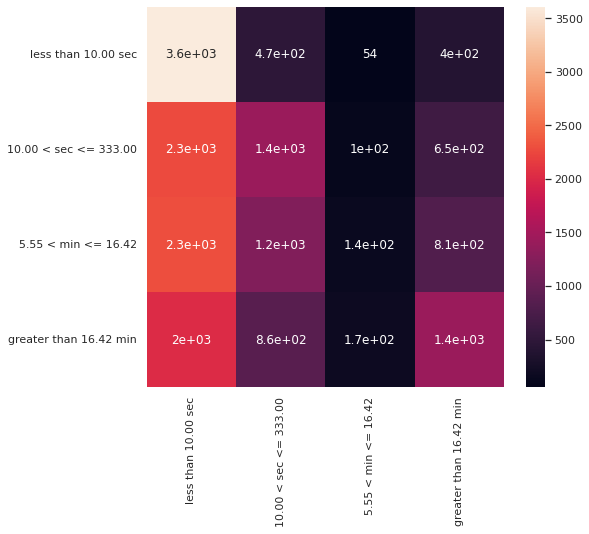

In [449]:
print(classification_report(y, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y,y_pred), annot=True, ax=ax, xticklabels=names, yticklabels=names)

If we are careful about regularizing the random forest model, it does a little bit better

In [450]:
lindf = pd.DataFrame()
lindf['seconds'] = df['Total Seconds Out']
lindf.fillna(0, inplace=True)
y = lindf['seconds'].values
r2max = 0
candidates = feeds.copy()
basemodel = lindf

labels = y.copy()
labels[labels <= np.quantile(y, .25)] = 1
labels[(labels > np.quantile(y, .25)) & (labels <= np.quantile(y, .5))] = 2
labels[(labels > np.quantile(y, .5)) & (labels <= np.quantile(y, .75))] = 3
labels[(labels > np.quantile(y, .75))] = 4

names = []
names += [f"less than {np.quantile(y, .25):.2f} sec"]
names += [f"{np.quantile(y, .25):.2f} < sec <= {np.quantile(y, .5):.2f}"]
names += [f"{np.quantile(y, .5)/60:.2f} < min <= {np.quantile(y, .75)/60:.2f}"]
names += [f"greater than {np.quantile(y, .75)/60:.2f} min"]

y = labels

ind = feeds
lindf[ind] = df[ind]
lindf.fillna(0, inplace=True)
X = lindf[ind].values#.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
print(f"Train Acc: {accuracy_score(y_train, model.predict(X_train)):.2f}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test)):.2f}")

Train Acc: 0.99
Test Acc: 0.39


              precision    recall  f1-score   support

         1.0       0.41      0.48      0.44       898
         2.0       0.33      0.30      0.31       881
         3.0       0.29      0.27      0.28       893
         4.0       0.50      0.51      0.51       908

    accuracy                           0.39      3580
   macro avg       0.38      0.39      0.38      3580
weighted avg       0.38      0.39      0.38      3580



<AxesSubplot:>

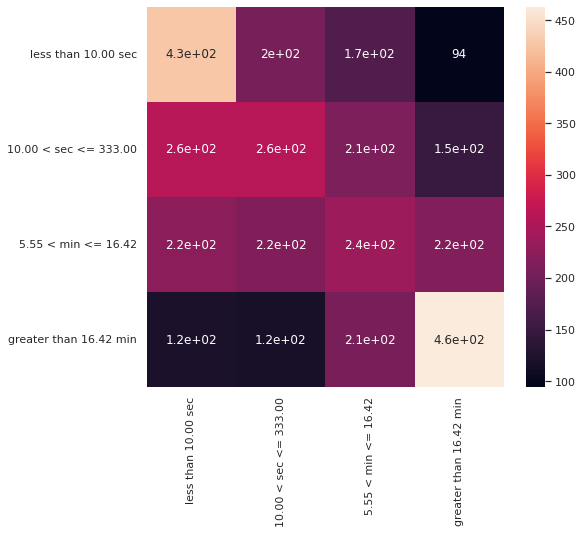

In [451]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, ax=ax, xticklabels=names, yticklabels=names)

In [452]:
# grab feature importances
imp = model.feature_importances_

# their std
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# create new dataframe
feat = pd.DataFrame([ind, imp, std]).T
feat.columns = ['feature', 'importance', 'std']
feat = feat.sort_values('importance', ascending=False)
feat = feat.reset_index(drop=True)
feat.dropna(inplace=True)
feat.head(20)


,feature,importance,std
0,PP TOTAL PPH 4065,0.150387,0.008053
1,BLACK SCHULMAN P7381,0.118158,0.008725
2,PP INEOS 100 GA04,0.100635,0.005217
3,UV ARGUS ARX V 16 706 UV PP,0.090776,0.006273
4,MFR 4 Grey,0.08828,0.005656
5,PP UNIPETROL GB005,0.060558,0.003569
6,MFR 4 Black,0.052589,0.003695
7,ADD SCHULMAN DTY 20 AOUV,0.041478,0.003554
8,DEVAN 2SPIN PP 106,0.038438,0.004061
9,High MFR Black,0.028838,0.002515


## 6.0 Business Impact

What is the so what?

From Hyp tests - target is either `'Total Position Out'` or `'Total Seconds Out'`

We had culprits from pearsons:

In [453]:
ind_vars

['MFR 4 White', 'PP TOTAL 7089', 'SILIKAT POLYPLUS AB 1001 PP']

culprits from non parametric tests:

In [454]:
list(problem_vars)

['PP TOTAL 7089',
 'PP POLYCHIM HB12XF',
 'High MFR Grey',
 'SILIKAT PBH ABPP 05',
 'BLACK SCHULMAN P7381']

and culprits from linear regression

In [461]:
forward_selection_feeds

Index(['PP TOTAL 7089', 'PP POLYCHIM HB12XF', 'SILIKAT PBH ABPP 05',
       'SILIKAT POLYPLUS AB 1001 PP', 'MFR 4 Green',
       'ADD SCHULMAN DTY 20 AOUV', 'GREEN SCHULMAN PZ 302446 1 5 T',
       'MFR 4 Grey', 'UV ARGUS ARX V 16 706 UV PP',
       'GREEN SCHULMAN PZ 34198 1 5 T'],
      dtype='object')

and we can check the overlap between non-parametric and linear regression (parametric):

In [462]:
predict_vars = [i for i in basemodel.columns if i in (problem_vars)]
predict_vars

['PP TOTAL 7089', 'PP POLYCHIM HB12XF', 'SILIKAT PBH ABPP 05']

In [578]:
all_vars = set(list(problem_vars) + list(forward_selection_feeds))
all_vars

{'ADD SCHULMAN DTY 20 AOUV',
 'BLACK SCHULMAN P7381',
 'GREEN SCHULMAN PZ 302446 1 5 T',
 'GREEN SCHULMAN PZ 34198 1 5 T',
 'High MFR Grey',
 'MFR 4 Green',
 'MFR 4 Grey',
 'PP POLYCHIM HB12XF',
 'PP TOTAL 7089',
 'SILIKAT PBH ABPP 05',
 'SILIKAT POLYPLUS AB 1001 PP',
 'UV ARGUS ARX V 16 706 UV PP'}

In [620]:
# add to DF
business = pd.DataFrame()
value_line_by_day = 99000
for ind in problem_vars:
    try:
        # products, 
        prods = df.loc[df[ind] > 0]['Product'].unique()
        nprods = df.loc[df[ind] > 0]['Product'].nunique()
        dff = df.loc[df['Product'].isin(prods)]
        # total runtime, 
        tot_runtime = dff['Time Delta'].sum()
        # total runtime with feed, 
        tot_runtime_wfeed = dff[dff[ind] > 0]['Time Delta'].sum()
        #downtime w/o feed, downtime w/ feed, 
        avg_downtime_min = dff.groupby(dff[ind] > 0)[seconds[:4]].mean().mean(1)/60
        avg_downtime_min_wfeed = avg_downtime_min[True]
        avg_downtime_min_w_ofeed = avg_downtime_min[False]
        ratio = avg_downtime_min_wfeed / avg_downtime_min_w_ofeed
        # average runtime, 
        avg_runtime_min = dff['Time Delta'].mean().total_seconds()/60
        # days saved, dollars saved
        days_saved = (tot_runtime_wfeed.total_seconds()/60 / avg_runtime_min * avg_downtime_min.diff().values[-1])/60/24
        
        dollars_saved_per_batch = value_line_by_day * avg_downtime_min.diff().values[-1] / (60*24)
        
        business = pd.concat((business, pd.DataFrame([[ind, nprods, tot_runtime, tot_runtime_wfeed, avg_downtime_min_wfeed, 
                                                       avg_downtime_min_w_ofeed, ratio, avg_runtime_min, days_saved, 
                                                       days_saved*value_line_by_day, dollars_saved_per_batch]],
                    columns=['Feed', 'Products', 'Total Runtime, Products', 'Total Runtime With Feed',
                             'Average Downtime With Feed', 'Average Downtime Without Feed', 'Downtime Mult X (with feed)', 
                             'Average Runtime', 'Days Saved (2 YRS)', 'Dollars Saved (2 YRS)', 'Dollars Saved (Per Batch)'])))
    except:
        print(ind)
        print(dff.groupby(df[ind] > 0)[seconds[:4]].mean().mean(1)/60)
business = business.sort_values('Dollars Saved (Per Batch)', ascending=False).reset_index(drop=True)
business
# workshop downtime ratio
# feed products, feed products
# Dollars saved per batch

,Feed,Products,"Total Runtime, Products",Total Runtime With Feed,Average Downtime With Feed,Average Downtime Without Feed,Downtime Mult X (with feed),Average Runtime,Days Saved (2 YRS),Dollars Saved (2 YRS),Dollars Saved (Per Batch)
0,SILIKAT PBH ABPP 05,26,409 days 20:43:21,94 days 04:36:05,26.250639,13.671063,1.920161,70.835736,16.727319,1.656005e+06,864.845823
1,High MFR Grey,36,564 days 04:13:41,94 days 12:26:59,23.623539,12.809036,1.844287,65.459164,15.615433,1.545928e+06,743.497080
2,PP POLYCHIM HB12XF,17,383 days 00:03:51,67 days 09:13:53,21.043525,15.600015,1.348943,70.908183,5.173013,5.121283e+05,374.241303
3,BLACK SCHULMAN P7381,64,751 days 20:01:57,590 days 12:21:50,14.902871,12.363943,1.205349,63.216276,23.716605,2.347944e+06,174.551301
4,PP TOTAL 7089,13,291 days 22:06:22,79 days 15:56:47,20.651050,18.269305,1.130369,80.146114,2.367430,2.343756e+05,163.744933


In [621]:
pd.set_option('display.precision', 2)
display(business[['Feed', 'Average Downtime With Feed', 'Average Downtime Without Feed',
                  'Downtime Mult X (with feed)', 'Days Saved (2 YRS)', 'Dollars Saved (2 YRS)', 
                  'Dollars Saved (Per Batch)']],
        )
pd.set_option('display.precision', 6)

,Feed,Average Downtime With Feed,Average Downtime Without Feed,Downtime Mult X (with feed),Days Saved (2 YRS),Dollars Saved (2 YRS),Dollars Saved (Per Batch)
0,SILIKAT PBH ABPP 05,26.25,13.67,1.92,16.73,1.66e+06,864.85
1,High MFR Grey,23.62,12.81,1.84,15.62,1.55e+06,743.50
2,PP POLYCHIM HB12XF,21.04,15.60,1.35,5.17,5.12e+05,374.24
3,BLACK SCHULMAN P7381,14.90,12.36,1.21,23.72,2.35e+06,174.55
4,PP TOTAL 7089,20.65,18.27,1.13,2.37,2.34e+05,163.74


We see that `'SILKAT PBH ABPP 05'` as well as `'High MFR Grey'` have a large amount of days saved over the two years, a strong downtime multiplier effect and the largest dollars saved per batch. Since High MFR Grey is a recycle feed, we may not have the ability to remove it from the feed list. Leaving the SILKAT (Silicate) feed the prime feedstock to remove

## 7.0 Visualizations

### PP TOTAL 7089

In [311]:
predict_var = predict_vars[1]
outcome_var = [i for i in df.columns if 'Seconds' in i]

def myplot(col=list(df.loc[df[predict_var] > 0]['Product'].unique())):
    fig, ax = plt.subplots(figsize=(20,10))
    axt = ax.twinx()
    
    # other feeds
    df.loc[df['Product'] == col][feeds].reset_index(drop=True).dropna(axis=1, how='all').plot(ls='', marker='*', ax=ax, alpha=0.2)
    
    # predict_var feed
    df.loc[df['Product'] == col][feeds].reset_index(drop=True)[predict_var].plot(ls='--', marker='+', ax=ax, lw=2, c='red')
    
    # outcome_var
    df.loc[df['Product'] == col][outcome_var].reset_index(drop=True).sum(1).plot(ls='-', marker='+', lw=1, ax=axt, alpha=1, c='blue',
                                                                                label='Total Seconds Out')
    
    # outliers
    ax.set_ylim(0)
    axt.set_ylim(0, 
                np.quantile(df.loc[df['Product'] == col][outcome_var].reset_index(drop=True).sum(1), 0.997))
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = axt.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc=0)

In [312]:
interact(myplot)

interactive(children=(Dropdown(description='col', options=(0.0, 125617.0, 55626.0, 110617.0, 260607.0, 165215.…

<function __main__.myplot(col=[0.0, 125617.0, 55626.0, 110617.0, 260607.0, 165215.0, 136215.0, 125215.0, 110215.0, 100215.0, 80215.0, 100617.0, 90617.0, 90215.0, 90216.0, 110520.0, 80617.0])>